This is the sequel of training_dnn.ipynb.

Here, we will discuss about loading a trained network, forwarding data to it and how to extract features maps.

In [1]:
from astropy.io import fits as fits
from matplotlib import pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize']=[12,8]


In [2]:
## Set up the sys.path in order to be able to import our modules
import os
import sys
module_path = os.path.abspath(os.path.join('../python'))
if module_path not in sys.path:
    sys.path.append(module_path)

First, you can load a model using load_model from Keras to load an hdf5 file containing a network (saved using save_model or a ModelCheckpoint also defined in Keras).

Otherwise, using the DeepNet class, you can call the constructor with the file.

In [3]:
## extra imports to set GPU options
import tensorflow as tf
from keras import backend as k

###################################
# TensorFlow wizardry
config = tf.ConfigProto()
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True

# Only allow a total of half the GPU memory to be allocated
# This line is optional, don't add it unless you really need to set a limit on the memory available for your process
# For instance, if you want to train 2 DNNs on the same GPU without one overlapping the memory needed by the other
# Change the value to set the percentage of memory allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.5 

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

# Now you can create/load your DNN

Using TensorFlow backend.


In [4]:
"""
Based on code written by alechat
"""

import os
import numpy as np
from subprocess import Popen, PIPE

def fits2npy(fits_file, idx_hdu):
    '''Read .fits containing the psf'''
    data = fits.getdata(fits_file, idx_hdu)
    nb_gal_row = data.shape[0]//96
    data_list = []
    idx_list = range(0, 10000)
    for i in idx_list:
        y = (96*i)%(nb_gal_row*96)
        x = i//nb_gal_row * 96
        data_list.append(data[x:x+96,y:y+96])
    return np.asarray(data_list)

def StampCollection2Mosaic(stamplist,gal_dim=96,nb_gal=10000):
    nb_gal_row = int(np.sqrt(nb_gal)) #nb galaxies per row
    mosaic=np.empty((nb_gal_row*gal_dim,nb_gal_row*gal_dim))
    for i in range(nb_gal):
        y = (gal_dim*i)%(nb_gal_row*gal_dim)
        x = i//nb_gal_row * gal_dim
        mosaic[x:x+gal_dim,y:y+gal_dim]=stamplist[i,:,:,0]
    return mosaic   

def compute_pixel_error(target_file, hdu_target, reconst_file, gal_dim=96, nb_gal=10000,xslice=slice(28,69,1),yslice=slice(28,69,1)):
    '''
    X: ground truth
    Y: estimated images
    '''
    nb_gal_row = int(np.sqrt(nb_gal)) #nb galaxies per row
    X = fits.getdata(target_file,hdu_target)
    Y = fits.getdata(reconst_file)
    DIFF=X-Y
    err = []
    for i in range(nb_gal):
        y = (gal_dim*i)%(nb_gal_row*gal_dim)
        x = i//nb_gal_row * gal_dim
        if gal_dim == 96:
            err.append((np.linalg.norm((DIFF[x:x+gal_dim,y:y+gal_dim])[xslice, 
                        yslice])**2)/(np.linalg.norm(X[x:x+gal_dim,y:y+gal_dim][xslice, yslice])**2))
        else:
            err.append((np.linalg.norm(DIFF[x:x+gal_dim,y:y+gal_dim])**2)/(np.linalg.norm(X[x:x+gal_dim,y:y+gal_dim])**2))
    return err

def generate_shape_txt(gal_file, psf_file, output_file, gal_dim=96, mosaic_size=100, save_weights='', weights_input=''):
    print('Computing ellipticity for file: %s'%(gal_file))
    print('Saving result in: %s'%(output_file))
    executable = '/data/shapelens_v2/shapelens-CEA-master/bin/get_shapes'
    if weights_input in '-o-i':
        cmd = '%s %s %s -p %s -g %d -s %d -T %s | tee %s'%(executable, weights_input, save_weights, psf_file, mosaic_size, gal_dim, gal_file, output_file)
    else:
        cmd = '%s -p %s -g %d -s %d -T %s | tee %s'%(executable, psf_file, mosaic_size, gal_dim, gal_file, output_file)
    print(cmd)
    cmd_file = 'get_shape.cmd'
    try:
        os.remove(cmd_file)
    except OSError:
        pass
    f = open(cmd_file, 'w')
    f.write('#! /bin/bash\n')
    f.write('source /home/fsureau/.bashrc\n')
    f.write(cmd)
    f.close()
    os.system('chmod 777 '+cmd_file)
    p = Popen('./'+cmd_file, stdout=PIPE, stderr=PIPE)
    stdout, stderr = p.communicate()
    return stdout, stderr

def get_target_shape(gal_file, output_file, idx=4):
    tmp_file = 'tmp'+str(np.random.randint(999))+'.fits'
    tmp_psf_file = 'tmp_psf'+str(np.random.randint(999))+'.fits'
    try:
        os.remove(tmp_file)
    except OSError:
        pass
    try:
        os.remove(tmp_psf_file)
    except OSError:
        pass
    images = fits.getdata(gal_file, idx)
    psfs = fits.getdata(gal_file, 3)
    fits.writeto(tmp_file, images)
    fits.writeto(tmp_psf_file, psfs)
    stdout, stderr = generate_shape_txt(tmp_file, tmp_psf_file, output_file)
    try:
        os.remove(tmp_file)
    except OSError:
        pass
    try:
        os.remove(tmp_psf_file)
    except OSError:
        pass
    return stdout, stderr

def get_ellipticity(file_name):
    ellip = []
    with open(file_name, 'r') as f:
        data = f.readlines()
    for l in data:
        ellip.append(np.array(l.split('\t')[3:5]).astype(np.float32))
    return np.asarray(ellip)

def compute_ellipticity_error(fileX, fileY, plot_hist=False, max_idx=10000):
    ellipX = get_ellipticity(fileX)[:max_idx]
    ellipY = get_ellipticity(fileY)[:max_idx]
    err = []
    for i in range(len(ellipY)):
        if (np.abs(ellipX[i]) > 1).any() or (np.abs(ellipY[i]) > 1).any():
            continue
        err.append(np.linalg.norm(ellipX[i]-ellipY[i]))
    if plot_hist:
        plt.figure()
        plt.hist(err, 100, range=(0,0.6))
        plt.show()
        print('Total samples = %d' %len(err))
    return err


def oracle_ellip(input_file, output_file, noise_std = 0):
    data = fits.getdata(input_file, 1)
    psf = fits.getdata(input_file, 3)
    if noise_std != 0:
        noise = np.random.normal(0, noise_std, size=data.shape)
        data += noise
    tmp_file = 'tmp'+str(np.random.randint(999))+'.fits'
    tmp_psf_file = 'tmp_psf'+str(np.random.randint(999))+'.fits'
    try:
        os.remove(tmp_file)
    except OSError:
        pass
    try:
        os.remove(tmp_psf_file)
    except OSError:
        pass
    fits.writeto(tmp_file, data)
    fits.writeto(tmp_psf_file, psf)
    generate_shape_txt(tmp_file, tmp_psf_file, output_file)
    try:
        os.remove(tmp_file)
    except OSError:
        pass
    try:
        os.remove(tmp_psf_file)
    except OSError:
        pass

## Get information about all networks

In [5]:
from DeepDeconv.deepnet.DeepNet import DeepNet
import os.path
import glob
net_path= '/home/fsureau/programs/DeepDeconv/'
nets=glob.glob(net_path+'*.hdf5')
nets.sort()
#net='/home/fsureau/programs/DeepDeconv/DeconvNet2D_FCS_sc4_layer5x5x5x5_swish_growthRate12_reshfl_SNR20to100.hdf5'
#for net in nets:
#    dnn = DeepNet(model_file=net)
#    print(os.path.split(net)[1])
#    print(int(np.sum([k.count_params(p) for p in set(dnn.model.trainable_weights)])))
#    print(int(np.sum([k.count_params(p) for p in set(dnn.model.non_trainable_weights)])))

In [6]:
testset_path = '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/'
testset_file = 'image-shfl-0-multihdu.fits'
a=fits.open(testset_path+testset_file)

To forward data through the network use the predict method available for both classes. For the method 2:

In [7]:
from DeepDeconv.deepnet.DeepNet import DeepNet
from DeepDeconv.utils.batch_utils import get_batch_from_fits
import numpy as np
import glob,os,fnmatch

# Input the file containing the galaxies and psfs for testing
#testset_path = '/data/DeepDeconv/data/vsc_euclidpsfs/'
#testset_file = 'image-000-0.fits'
testset_path = '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/'
testset_file = 'image-shfl-0-multihdu.fits'
noiseless_img_hdu = 0
psf_hdu = 1
targets_hdu = 2

data_directory = '/data/DeepDeconv/data/vsc_euclidpsfs/'
write_path="/data/DeepDeconv/benchmark/euclidpsf/"

#SNR_list_sim=[20,40,60,80,100]
SNR_list_sim=[20]

net_path= '/home/fsureau/programs/DeepDeconv/nets/'
net_file_list=fnmatch.filter(os.listdir(net_path),'*.hdf5')
net_file_list.sort()




## Process test set

In [8]:
from DeepDeconv.deepnet.DeepNet import DeepNet
from DeepDeconv.utils.batch_utils import get_batch_from_fits
import numpy as np
import glob,os,fnmatch

# Input the file containing the galaxies and psfs for testing
#testset_path = '/data/DeepDeconv/data/vsc_euclidpsfs/'
#testset_file = 'image-000-0.fits'
testset_path = '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/'
testset_file = 'image-shfl-0-multihdu.fits'
noiseless_img_hdu = 0
psf_hdu = 1
targets_hdu = 2

data_directory = '/data/DeepDeconv/data/vsc_euclidpsfs/'
write_path="/data/DeepDeconv/benchmark/euclidpsf/"

#SNR_list_sim=[20,40,60,80,100]
SNR_list_sim=[20]

net_path= '/home/fsureau/programs/DeepDeconv/nets/'
net_file_list=fnmatch.filter(os.listdir(net_path),'*.hdf5')
net_file_list.sort()


for net_file in net_file_list:
    print("net_file={0}".format(net_file))
    for SNR_sim in SNR_list_sim:
        mosaic_name=testset_file.replace('.fits','-'+net_file.replace('.hdf5','_testSNR{0}.fits'.format(SNR_sim)))
        if os.path.isfile(write_path+'images/'+mosaic_name):
            print("Do not process {0}".format(mosaic_name))
        else:
            print("Process {0}".format(mosaic_name))
            if 'dnn' not in locals():
                dnn = DeepNet(model_file=net_path+net_file) #dnn is instance of DeepNet class

            if "risk" in net_file:
                deconv_mode="TIKHONOV_FCS"
                if "regDirac" in net_file:
                    reg_mode="Dirac"
                elif "regLap" in net_file:
                    reg_mode="Lap"
                if "riskGCV" in net_file:
                    risktype="GCV"
                elif "riskSurePred" in net_file:
                    risktype="SurePred"
                elif "riskSureProj" in net_file:
                    risktype="SureProj"
                elif "riskPereyra" in net_file:
                    risktype="Pereyra"
            else:
                deconv_mode="TIKHONOV"
                reg_mode=""
                risktype=""
            print("Process {0}, deconv={1}, reg={2}, risk={3}".format(net_file,deconv_mode,reg_mode,risktype))
            test_data, target_data = get_batch_from_fits(testset_path+testset_file, idx_list=np.arange(10000), SNR=SNR_sim,
                        noiseless_img_hdu=noiseless_img_hdu, targets_hdu=targets_hdu, psf_hdu=psf_hdu,
                        image_dim=96, image_per_row=100,
                         deconv_mode=deconv_mode, risktype= risktype,reg=reg_mode,tol=1e-8)
            dnn_reconstruction = dnn.predict(test_data, verbose=1)
            mosaic=StampCollection2Mosaic(dnn_reconstruction)
            hdu_dnn=fits.PrimaryHDU(mosaic)
            hdul = fits.HDUList([hdu_dnn])
            hdul.writeto(write_path+'images/'+mosaic_name,overwrite=True)
    if 'dnn' in locals():
        del dnn


#net_file = 'DeconvNetRef_FCS_train2to20_val1_vsc_rangeSNR20to100.hdf5'
#net_file = 'UNet2D_FCS_sc2_layer2x2_relu_filt8_resNet.hdf5'
#net_file='UNet2D_FCS_sc3_layer4x4x4_relu_filt16_reshfl_SNR20to100.hdf5'
#net_file='DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_reshfl_SNR20to100.hdf5'
#net_file='UNet2D_FCS_sc3_layer4x4x4_relu_filt16_resNet_reshfl_SNR20to100.hdf5'
#dnn = DeepNet(model_file=net_path+net_file) #dnn is instance of DeepNet class

# Create the set of test with 10 observations at SNR 50
#write_path="/data/DeepDeconv/benchmark/euclidpsf/"
#for SNR_sim in SNR_list_sim:
#    test_data, target_data = get_batch_from_fits(testset_path+testset_file, idx_list=np.arange(10000), SNR=SNR_sim,
#                        noiseless_img_hdu=noiseless_img_hdu, targets_hdu=targets_hdu, psf_hdu=psf_hdu,
#                        image_dim=96, image_per_row=100,
#                         deconv_mode='TIKHONOV')

#     dnn_reconstruction = dnn.predict(test_data, verbose=1)
#     mosaic=StampCollection2Mosaic(dnn_reconstruction)
#     hdu_dnn=fits.PrimaryHDU(mosaic)
#     hdul = fits.HDUList([hdu_dnn])
#     mosaic_name=testset_file.replace('.fits','-'+net_file.replace('.hdf5','_testSNR{0}.fits'.format(SNR_sim)))
#     hdul.writeto(write_path+'images/'+mosaic_name,overwrite=True)


net_file=DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_atrou_reshfl_SNR20to100_reshfl_SNR20to100.hdf5
Do not process image-shfl-0-multihdu-DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_atrou_reshfl_SNR20to100_reshfl_SNR20to100_testSNR20.fits
net_file=DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_reshfl_SNR20to100.hdf5
Do not process image-shfl-0-multihdu-DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_reshfl_SNR20to100_testSNR20.fits
net_file=DeconvNet2D_FCS_sc4_layer4x5x6x7_relu_growthRate12_reshfl_SNR20to100.hdf5
Do not process image-shfl-0-multihdu-DeconvNet2D_FCS_sc4_layer4x5x6x7_relu_growthRate12_reshfl_SNR20to100_testSNR20.fits
net_file=DeconvNet2D_FCS_sc4_layer4x5x6x7_swish_growthRate12_reshfl_SNR20to100.hdf5
Do not process image-shfl-0-multihdu-DeconvNet2D_FCS_sc4_layer4x5x6x7_swish_growthRate12_reshfl_SNR20to100_testSNR20.fits
net_file=DeconvNet2D_FCS_sc4_layer5x5x5x5_relu_growthRate12_reshfl_SNR20to100.hdf5
Do not process image-shfl-0-multihdu-DeconvNet2D_FCS_sc4_la

## Compute Pixel Error

In [ ]:
import sharedmem as sm
AFFINITY_FLAG = False

def sharedmem_pool(total_cores, numexpr=True):
    # see https://stackoverflow.com/questions/15639779
    global AFFINITY_FLAG
    if not AFFINITY_FLAG:
        AFFINITY_FLAG = True
        os.system("taskset -p 0xfff %d" % os.getpid())
    if total_cores is None:
        total_cores = sm.cpu_count()
    return sm.MapReduce(np=good_process_number(total_cores, numexpr))


In [ ]:
import glob,os,fnmatch
testset_file = 'image-shfl-0-multihdu.fits'
target_name="images/target-shfl-0-multihdu.fits"
net_path= '/home/fsureau/programs/DeepDeconv/'

net_file_list=fnmatch.filter(os.listdir(net_path),'*.hdf5')
net_file_list.sort()

SNR_list_sim=[20,40,60,80,100]

# Create the set of test with 10 observations at SNR 50
write_path="/data/DeepDeconv/benchmark/euclidpsf/"
for net_file in net_file_list:
    print(net_file)
    for SNR_sim in SNR_list_sim:
        mosaic_name=testset_file.replace('.fits','-'+net_file.replace('.hdf5','_testSNR{0}.fits'.format(SNR_sim)))
        if os.path.isfile(write_path+'images/'+mosaic_name):
            write_txt_name=write_path+'stats/'+mosaic_name.replace('.fits','_pixelerr.txt')
            if not os.path.isfile(write_txt_name):
                print("Compte Pixel error {0}".format(mosaic_name) )
                err=compute_pixel_error(write_path+target_name, 0, write_path+'images/'+mosaic_name, gal_dim=96, nb_gal=10000,xslice=slice(28,69,1),yslice=slice(28,69,1))
                np.savetxt(write_txt_name,np.array(err))
            else:
                err=np.loadtxt(write_txt_name)
            print("SNR=",SNR_sim,"MEAN_ERR=",np.median(err),"MEDIAN_ERR=",np.median(err))
        else:
            print("not existing {0}".format(mosaic_name) )
            
        def work(i):
            spect_norm = np.linalg.norm(spectrograms[i])
            fourier_norms[i] = spect_norm
            space_norms[i] = spect_norm / math.sqrt(spectrograms[i].size)

        pool.map(work, list(range(len(spectrograms))))
            


## Compute Ellipticity Error

In [ ]:
#Create Mosaic and save it
testset_file = 'image-shfl-0-multihdu.fits'
target_name=testset_file.replace('.fits','-target_fwhm0p07.fits')
save_weights=write_path+'ellip/'+target_name.replace('.fits','_weights.fits')

#perform target ellipticity measurements
psf_file="/data/DeepDeconv/data/gauss_fwhm0p07/starfield_image-000-0.fits"
ellip_filename=write_path+'ellip/'+target_name.replace('.fits','_ellipmes.txt')
#generate_shape_txt(write_path+'images/'+target_name, psf_file, ellip_filename, mosaic_size=100, save_weights=save_weights, weights_input='-o')

In [ ]:
# psf_file="/data/DeepDeconv/data/gauss_fwhm0p07/starfield_image-000-0.fits"
# ellip_filename=write_path+'ellip/'+target_name.replace('.fits','_ellipmes.txt')
# save_weights=write_path+'ellip/'+target_name.replace('.fits','_weights.fits')
# SNR_list_sim=[20,40,60,80,100]
# for SNR_sim in SNR_list_sim:
#     mosaic_name=target_name.replace('.fits','_SNR{0}.fits'.format(SNR_sim))
#     ellip_filename=write_path+'ellip/'+mosaic_name.replace('.fits','_ellipmes_targetweights.txt')
#     generate_shape_txt(write_path+'images/'+mosaic_name, psf_file, ellip_filename, mosaic_size=100, save_weights=save_weights, weights_input='-i')

In [ ]:
# psf_file="/data/DeepDeconv/data/gauss_fwhm0p07/starfield_image-000-0.fits"
# ellip_filename=write_path+'ellip/'+target_name.replace('.fits','_ellipmes.txt')

# SNR_list_sim=[20,40,60,80,100]
# for SNR_sim in SNR_list_sim:
#     mosaic_name=target_name.replace('.fits','_SNR{0}.fits'.format(SNR_sim))
#     ellip_filename=write_path+'ellip/'+mosaic_name.replace('.fits','_ellipmes_targetweights_SNR{0}.txt'.format(SNR_sim))
#     save_weights=write_path+'ellip/'+target_name.replace('.fits','_weights_SNR{0}.fits'.format(SNR_sim))
# #     generate_shape_txt(write_path+'images/'+mosaic_name, psf_file, ellip_filename, mosaic_size=100, save_weights=save_weights, weights_input='-o')

In [ ]:
import glob,os,fnmatch
testset_file = 'image-shfl-0-multihdu.fits'
target_name="images/target-shfl-0-multihdu.fits"
net_path= '/home/fsureau/programs/DeepDeconv/'

net_file_list=fnmatch.filter(os.listdir(net_path),'*.hdf5')
net_file_list.sort()

psf_file="/data/DeepDeconv/data/gauss_fwhm0p07/starfield_image-000-0.fits"
save_weights=write_path+'ellip/'+target_name.replace('.fits','_weights.fits')

SNR_list_sim=[20,40,60,80,100]
# Create the set of test with 10 observations at SNR 50
write_path="/data/DeepDeconv/benchmark/euclidpsf/"
for net_file in net_file_list:
    print(net_file)
    for SNR_sim in SNR_list_sim:
        mosaic_name=testset_file.replace('.fits','-'+net_file.replace('.hdf5','_testSNR{0}.fits'.format(SNR_sim)))
        if os.path.isfile(write_path+'images/'+mosaic_name):
            ellip_filename=write_path+'ellip/'+mosaic_name.replace('.fits','_ellipmes_targetweights_SNR{0}.txt'.format(SNR_sim))
            if not os.path.isfile(write_txt_name):
                print("Compte Pixel error {0}".format(mosaic_name) )
                generate_shape_txt(write_path+'images/'+mosaic_name, psf_file, ellip_filename, mosaic_size=100, save_weights=save_weights, weights_input='-i')
            else:
                err=np.loadtxt(ellip_filename)
            print("SNR=",SNR_sim,"MEAN_ERR=",np.median(err),"MEDIAN_ERR=",np.median(err))
        else:
            print("not existing {0}".format(mosaic_name) )



(<matplotlib.axes._subplots.AxesSubplot at 0x7f6e42b11ef0>,
 <matplotlib.colorbar.Colorbar at 0x7f6e42a9b898>)

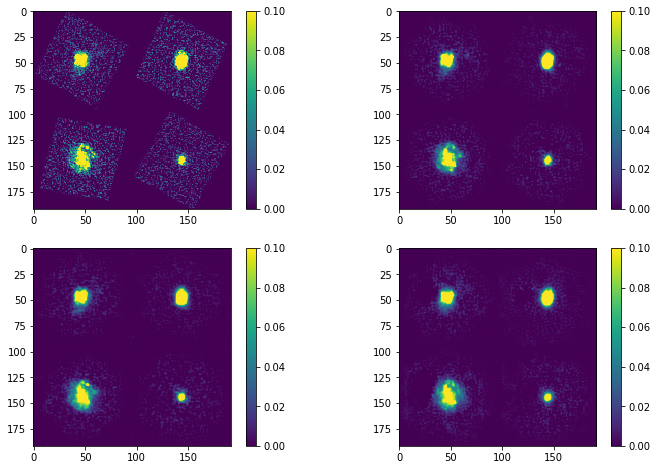

In [63]:
#Explore various results:
write_path="/data/DeepDeconv/benchmark/euclidpsf/"
target_name=testset_file.replace('.fits','-target_fwhm0p07.fits')
SNR=100
target=fits.getdata(write_path+'images/'+target_name)
unet4x4x4_name=write_path+"images/image-shfl-0-multihdu-UNet2D_FCS_sc3_layer4x4x4_relu_filt16_reshfl_SNR20to100_testSNR{0}.fits".format(SNR)
unet4x4x4=fits.getdata(unet4x4x4_name)
unet4x4x4_res_name=write_path+"images/image-shfl-0-multihdu-UNet2D_FCS_sc3_layer4x4x4_relu_filt16_resNet_reshfl_SNR20to100_testSNR{0}.fits".format(SNR)
unet4x4x4_res=fits.getdata(unet4x4x4_res_name)
deconvnet_name=write_path+"images/image-shfl-0-multihdu-DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_reshfl_SNR20to100_testSNR{0}.fits".format(SNR)
deconvnet=fits.getdata(deconvnet_name)

plt.subplot(2,2,1),plt.imshow(target[0:192,0:192],vmin=0,vmax=0.1),plt.colorbar()
plt.subplot(2,2,2),plt.imshow(unet4x4x4[0:192,0:192],vmin=0,vmax=0.1),plt.colorbar()
plt.subplot(2,2,3),plt.imshow(unet4x4x4_res[0:192,0:192],vmin=0,vmax=0.1),plt.colorbar()
plt.subplot(2,2,4),plt.imshow(deconvnet[0:192,0:192],vmin=0,vmax=0.1),plt.colorbar()


In [ ]:
if 'dnn' in locals():
    del dnn
k.clear_session()
